In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label

img_dir = "../output_images/"

In [3]:
def bin_spatial(img, size=(32, 32)):
    """Compute binned color features"""
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32, bins_range=(0, 256)):
    """Compute color histogram features"""
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell = (pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  visualise=vis, feature_vector=feature_vec,
                                  block_norm="L2-Hys")
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, 
                       pixels_per_cell = (pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       visualise=vis, feature_vector=feature_vec,
                       block_norm="L2-Hys")
        return features

In [5]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Load Dataset

In [6]:
images = glob.glob("../data/*/*/*.png")
cars = []
notcars = []
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

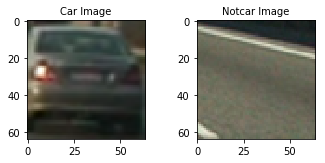

In [7]:
# Random idx
idx_car = np.random.randint(0, len(cars))
idx_notcar = np.random.randint(0, len(notcars))
img_car = mpimg.imread(cars[idx_car])
img_notcar = mpimg.imread(notcars[idx_notcar])
# Show example images of car and notcar
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(4,3))
f.tight_layout()
ax1.imshow(img_car)
ax1.set_title('Car Image', fontsize=10)
ax2.imshow(img_notcar)
ax2.set_title('Notcar Image', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig(img_dir + "car_not_car.png", dpi=300, bbox_inches='tight')

### HOG Visulization

In [8]:
# Params initialization
feature_params = {'orient': 11,
                  'pix_per_cell': 16,
                  'cell_per_block': 2,
                  'hog_channel': 'ALL',
                  'spatial_size': (32,32),
                  'hist_bins': 32,
                  'spatial_feat': False,
                  'hist_feat': True,
                  'hog_feat': True,
                  'color_space': 'YCrCb'}

In [9]:
color_space = feature_params['color_space']
orient = feature_params['orient']
pix_per_cell = feature_params['pix_per_cell']
cell_per_block = feature_params['cell_per_block']
spatial_size = feature_params['spatial_size']
hist_bins = feature_params['hist_bins']
hog_channel = feature_params['hog_channel']
spatial_feat = feature_params['spatial_feat']
hist_feat = feature_params['hist_feat']
hog_feat = feature_params['hog_feat']

In [10]:
gray_car = cv2.cvtColor(img_car, cv2.COLOR_RGB2GRAY)
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray_car, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

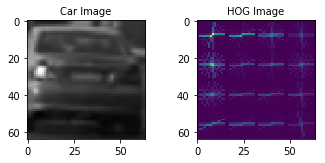

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 3))
f.tight_layout()
ax1.imshow(gray_car, cmap='gray')
ax1.set_title('Car Image', fontsize=10)
ax2.imshow(hog_image)
ax2.set_title('HOG Image', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig(img_dir + "hog_example.png", dpi=300, bbox_inches='tight')

### Extract Features

In [12]:
# Extract features
car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

In [13]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [14]:
# Check mean and variance of train and test dataset
print("Train dataset:")
print("mean is {:.2f} and variance is {:.2f}".format(X_train.mean(), X_train.var()))
print("Test dataset:")
print("mean is {:.2f} and variance is {:.2f}".format(X_test.mean(), X_test.var()))

Train dataset:
mean is 0.00 and variance is 0.93
Test dataset:
mean is 0.00 and variance is 1.05


In [15]:
# Save the features
feature_pickle = {}
feature_pickle['X_scaler'] = X_scaler
feature_pickle['X_train'] = X_train
feature_pickle['X_test'] = X_test
feature_pickle['y_train'] = y_train
feature_pickle['y_test'] = y_test

filename = "feature_pickle.p"
pickle.dump(feature_pickle, open( filename, "wb" ) )

### Train Classifier

In [16]:
# load the model from disk
filename = "feature_pickle.p"
feature_pickle = pickle.load(open(filename, 'rb'))

X_train = feature_pickle['X_train']
X_test = feature_pickle['X_test']
y_train = feature_pickle['y_train']
y_test = feature_pickle['y_test']

In [17]:
print('Using:',orient,'orientations',pix_per_cell,
      'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=0.01, max_iter=100)
# Fit the linear SVC classifier
svc.fit(X_train, y_train)
# Check the score of the SVC
score = svc.score(X_test, y_test)
print('Test Accuracy of SVC = {:.4f}'.format(score))

n_predict = 10
print('SVC predicts: ', svc.predict(X_test[0:n_predict]))
print(n_predict, 'labels: ', y_test[0:n_predict])

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1284
Test Accuracy of SVC = 0.9755
SVC predicts:  [ 0.  0.  0.  1.  1.  1.  1.  0.  0.  0.]
10 labels:  [ 0.  0.  0.  1.  1.  1.  1.  0.  0.  0.]


In [18]:
# Save the classifier
model_pickle = {}
model_pickle['model'] = svc
model_pickle['params'] = feature_params

filename = "model_pickle.p"
pickle.dump(model_pickle, open(filename, 'wb'))

### Sliding Windows

In [19]:
# load the model from disk
filename = "model_pickle.p"
model_pickle = pickle.load(open(filename, 'rb'))
svc = model_pickle['model']
feature_params = model_pickle['params']

In [20]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

In [21]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, scale, svc, X_scaler, feature_params, ystart, ystop):
    # Params
    orient = feature_params['orient']
    pix_per_cell = feature_params['pix_per_cell']
    cell_per_block = feature_params['cell_per_block']
    spatial_size = feature_params['spatial_size']
    hist_bins = feature_params['hist_bins']

    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    img = img.astype(np.float32)/255.
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
#             spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append(((xbox_left,ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return box_list

In [22]:
def multi_scale(img, scales, svc, X_scaler, feature_params):
    # Params
    draw_img = np.copy(img)
    box_lists = []
    for scale in scales:
        if scale < 1.5:
            ystart = 400
            ystop = 580
        else:
            ystart = 400
            ystop = 660
        box_list = find_cars(img, scale, svc, X_scaler, feature_params, ystart, ystop)
        box_lists.append(box_list)
        for box in box_list:
            cv2.rectangle(draw_img,box[0],box[1],(0,0,255),5)
    return draw_img, box_lists

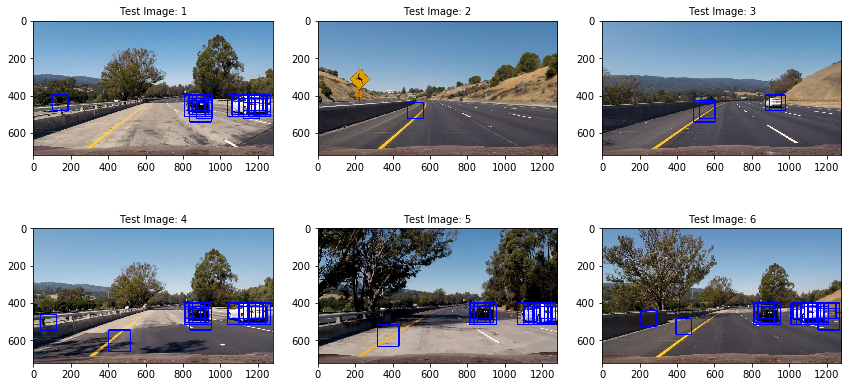

In [23]:
test_images = glob.glob("../test_images/*.jpg")
i = 0
plt.figure(figsize=(12,6))
for test_image in test_images:
    test_num = len(test_images)
    image = mpimg.imread(test_image)
    scales = [1.3, 1.8]
    out_img, box_lists = multi_scale(image, scales, svc, X_scaler, feature_params)
    
    plt.subplot(2,3,i+1)
    plt.imshow(out_img)
    plt.title('Test Image: {}'.format(i+1), fontsize=10)
    i += 1
plt.tight_layout()
plt.savefig(img_dir + "boxes.png", dpi=300, bbox_inches='tight')

### Multiple Detections & False Positive

In [24]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 8)
    # Return the image
    return img

In [25]:
def draw_heat_box(img, box_lists, heat_threshold):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    for box_list in box_lists:
        heat = add_heat(heat, box_list)

    heatmap_thresh = apply_threshold(heat, heat_threshold)
    heatmap = np.clip(heatmap_thresh, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img, heatmap

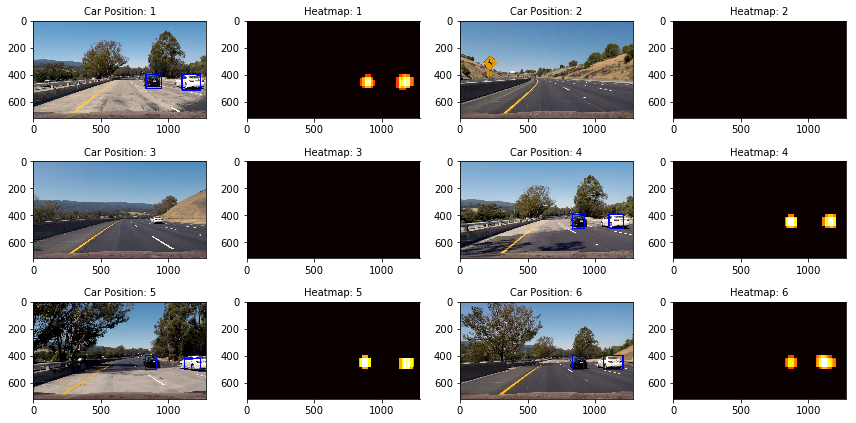

In [26]:
test_images = glob.glob("../test_images/*.jpg")
i = 0
j = 0
plt.figure(figsize=(12,6))
for test_image in test_images:
    image = mpimg.imread(test_image)
    scales = [1.3, 1.8]
    out_img, box_lists = multi_scale(image, scales, svc, X_scaler, feature_params)
    draw_img, heatmap = draw_heat_box(image, box_lists, 4)
    
    plt.subplot(3,4,i+1)
    plt.imshow(draw_img)
    plt.title('Car Position: {}'.format(j+1), fontsize=10)
    i += 1

    plt.subplot(3,4,i+1)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heatmap: {}'.format(j+1), fontsize=10)
    i += 1    
    j += 1
    
plt.tight_layout()
plt.savefig(img_dir + "heatmap.png", dpi=300, bbox_inches='tight')